# Hopfield - Self-attention
The update of the new energy function (notebook [3_hopfield-continuous-value.ipynb](./3_hopfield-continuous-value.ipynb)) is the self-attention of transformer networks.

References:
* https://ml-jku.github.io/hopfield-layers/#update

From equation:
$$
\xi^{new} = X\mathrm{softmax}(\beta X^T \xi)
$$

For $S$ state patterns $\Xi=(\xi_1,...,\xi_s)$, the equation can be generalized to:
$$
\Xi^{\mathrm{new}} = X\mathrm{softmax}(\beta X^T\Xi)
$$

Where $X^T$ can be considered as $N$ *raw **stored** patterns* $Y=(y_1,...y_N)^T$, which are mapped to an associative space via $W_K$, and $\Xi^T$ as $S$ *raw **state** patterns* $R=(\xi_1,...,\xi_S)^T$, which are mapped to an associative space via $W_Q$.

Then, by setting:
$$
Q = \Xi^T = RW_Q \\
K = X^T = YW_K \\
\beta = \frac{1}{\sqrt{d_k}}
$$

we obtain:
$$
(Q^{\mathrm{new}})^T = K^T \mathrm{softmax}(\frac{1}{\sqrt{d_k}}KQ^T)
$$

Where $W_Q$ and $W_K$ are matrices which map the respective patterns into the associative space. In the previous equation, the softmax is applied column-wise tot he matrix $KQ^T$. By transposing the equation, which also means softmax is now applied row-wise to its transposed input $QK^T$, we obtain:

$$
(Q^{\mathrm{new}})^T = \mathrm{softmax}(\frac{1}{\sqrt{d_k}}QK^T)K
$$

Now, by projecting $Q^{new}$ via another projection matrix $W_V$ we obtain:

$$
Z = Q^{new}W_V = \mathrm{softmax}(\frac{1}{\sqrt{d_k}}QK^T)KW_V = \mathrm{softmax}(\frac{1}{\sqrt{d_k}}QK^T)V
$$

Which is basically the transformer attention formula (As per Attention is All you need):
$$
\mathrm{Attention(Q, K, V)} = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

Some remarks:
* Transformer based models usually implement embedding layers before the attention mechanism, i.e., what is feed into the attention mechanism is an embedding of the input/outputs.
    * These embeddings have trainable matrices that produces them during training.
* In the new Hopfield definition, the matrices that produce the embeddings are explicit in the formula, i.e., matrices $W_Q$, $W_K$, and $W_V$ are the matrices that transform the input/outpus into the associative space that is feed to the attention mechanism.
* One differencing aspect of original attention vs Hopfield is the value of $\beta$ parameter. Original attention fixes this to be dependent on the dimension of the embeddings, which for large values of $d_k$ will yield in smaller $\beta$, which in turn, as per explained in the new Hopfield paper, means the retrievals will tend to be metastable states or the average of similar patterns which can give us an intuition of why they work and why the concept of "Attention".
* The new Hopfield definition can be interpreted as a generalization of the attention mechanism.
* The result of the retrieval, which is the attention produced from the state patterns against the stored patterns, can be the input to fully connected layers for some classification task.
* Similarly, before the attention mechanism, there can be other feature extraction layers s.a. CNNs that will produce vectors for which store/retrieval process can be applied.

## Hopfield MNIST #1 - Predict using full patterns


In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F

random_seed = 1234
train_split_fraction = 0.7
np.random.seed(random_seed)
torch.manual_seed(random_seed)

data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

train_set = MNIST(
    './mnist-train', 
    train=True, 
    download=True, 
    transform=data_transform,
    )

test_set = MNIST(
    './mnist-test', 
    train=False, 
    download=True, 
    transform=data_transform,
    )

train_set_size = len(train_set)
indices = list(range(train_set_size))
np.random.shuffle(indices)
split = int(np.floor(train_split_fraction * train_set_size))
stored_patterns_idx, train_idx = indices[split:], indices[:split]

stored_patterns_sampler = SubsetRandomSampler(stored_patterns_idx)
train_sampler = SubsetRandomSampler(train_idx)

train_loader = DataLoader(train_set, batch_size=2048, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=2048, shuffle=True, num_workers=4)
stored_patterns_loader = DataLoader(train_set, batch_size=split, sampler=stored_patterns_sampler)
stored_patterns = list(stored_patterns_loader)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def prepare_device(obj, use_cuda: bool = True):
    if use_cuda and torch.cuda.is_available():
        return obj.to("cuda")
    return obj

In [19]:
import torch.nn as nn
import torch

class HopfieldNet(nn.Module):
    def __init__(
        self,
        store_dim: int, 
        hidden_store_dim: int, 
        state_dim: int, 
        hidden_state_dim: int, 
        value_dim: int,
        hidden_value_dim: int,
        learn_v: bool = True):
        super().__init__()
        
        self.store_dim = store_dim
        self.hidden_store_dim = hidden_store_dim
        self.state_dim = state_dim
        self.hidden_state_dim = hidden_state_dim
        self.value_dim = value_dim
        self.hidden_value_dim = hidden_value_dim
        self.device = device
        self.learn_v = learn_v

        self.__init_parameters()
        # self._reset_parameters()
    
    def __init_parameters(self):
        # state patterns
        self.WQ = nn.Linear(self.state_dim, self.hidden_state_dim)
        # stored patterns
        self.WK = nn.Linear(self.store_dim, self.hidden_store_dim)
        # value patterns
        if self.learn_v:
            self.WV = nn.Linear(self.value_dim, self.hidden_value_dim)

    def to(self, device: str):
        super().to(device)
        self.WQ = self.WQ.to(device)
        self.WK = self.WK.to(device)
        if self.learn_v:
            self.WV = self.WV.to(device)
        return self

    def _reset_parameters(self):
        nn.init.normal_(self.WQ, 0., 0.01)
        nn.init.normal_(self.WK, 0., 0.01)
        if self.learn_v:
            nn.init.normal_(self.WV, 0., 0.01)

    def print_shapes(self):
        print(f"WQ: {self.WQ.shape}")
        print(f"WK: {self.WK.shape}")
        print(f"WV: {self.WV.shape}")
        

    def forward(self, state_patterns, stored_patterns, value_patterns=None, beta=1.0):
        Q = state_patterns / torch.norm(state_patterns, dim=1, keepdim=True)
        K = stored_patterns / torch.norm(stored_patterns, dim=1, keepdim=True)

        Q = self.WQ(Q)
        K = self.WK(K)

        if self.learn_v:
            V = self.WV(value_patterns)
            Z = torch.log_softmax(beta * Q @ K.T, dim=1) @ V
        else:
            Z = torch.log_softmax(beta * Q @ K.T, dim=1)
        return Z 

In [23]:
store_dim = 784 # 784 = 28 * 28, i.e., flattened images
state_dim = store_dim # stored and state paterns have the same dim
value_dim = 10 # the one-hot expected label from the state patterns
hidden_store_dim, hidden_state_dim = 64, 64
hidden_value_dim = value_dim # We don't need to embeed in a lower dimension the one hot encoding

model = HopfieldNet(
    store_dim, 
    hidden_store_dim, 
    state_dim, 
    hidden_state_dim, 
    value_dim, 
    hidden_value_dim,
    learn_v=True)
model = prepare_device(model)
num_params = sum([p.numel() for p in model.parameters()])
print(f"Total number of parameters in model: {num_params}")

Total number of parameters in model: 100590


Shape operations test

In [25]:
# model.print_shapes()
sim_raw_state = torch.randn((20, 784)).to(device)
sim_raw_stored = torch.randn((200, 784)).to(device)
sim_raw_value = torch.randn((200, 10)).to(device)
result = model(sim_raw_state, sim_raw_stored, sim_raw_value)
print(f"Shape of Result: {result.shape}")
assert list(result.shape) == [20, 10], "Result shape doesn't match with the expected result"


Shape of Result: torch.Size([20, 10])


In [26]:
import torch.optim as optim
import torchmetrics

loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
metric = torchmetrics.Accuracy()

In [7]:
from tqdm import tqdm
import torch.nn.functional as F
from tensorboardX import SummaryWriter

def train_loop(
    dataloader, 
    model, 
    split_size,
    beta,
    loss_fn, 
    optimizer):
    for R, y in dataloader:
        batch = prepare_device(R).view(-1, 28 * 28)
        y = prepare_device(y)
        state_patterns = batch[:split_size]
        store_patterns = batch[split_size:]
        value_patterns = F.one_hot(y[split_size], num_classes=10)

        optimizer.zero_grad()
        pred = model(state_patterns, store_patterns, value_patterns, beta=beta)
        loss = loss_fn(pred, y)        
        loss.backward()
        optimizer.step()

    return loss.item()


def evaluate(
    dataloader, 
    model,
    split_size, 
    beta,
    metric_fn):
    model.eval()
    with torch.no_grad():
        for R, y in dataloader:
            batch = prepare_device(R).view(-1, 28 * 28)
            y = prepare_device(y)
            state_patterns = batch[:split_size]
            store_patterns = batch[split_size:]
            value_patterns = F.one_hot(y[split_size], num_classes=10)

            preds = model(state_patterns, store_patterns, value_patterns, beta=beta).to("cpu")
            metric = metric_fn(preds, y)
        metric = metric_fn.compute()
        metric_fn.reset()
    return metric


def log(logger: SummaryWriter, loss, metric, model, step):
    logger.add_scalar('loss', loss, global_step=step)
    logger.add_scalar('accuracy', metric, global_step=step)
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        else:
            logger.add_histogram(
                tag=f'grads/{name}', 
                values=p.grad.detach().cpu().numpy(),
                global_step=step
            )
    logger.flush()

def train(
    epochs, 
    dataloader, 
    model,
    split_size, 
    loss_fn, 
    optimizer, 
    metric_fn,
    beta,
    logger: SummaryWriter):
    model.train()
    with tqdm(total=epochs) as progress:
        for i in range(epochs):
            loss = train_loop(
                dataloader, 
                model,
                split_size,
                beta,
                loss_fn, 
                optimizer)
            metric = evaluate(
                dataloader, 
                model, 
                split_size,
                beta,
                metric_fn)

            log(logger, loss, metric, model, i)

            progress.set_postfix({
                        "loss": f"{loss:.2f}",
                        "accuracy": f"{metric:.2f}"
                    })
            progress.update()

        

In [8]:
K = stored_patterns[0][0] # Stored patterns K
V = stored_patterns[0][1] # Stored patterns labels / values V
K = K.view(-1, 28*28) # row vectors (batch, 784)
K = prepare_device(K)
V = prepare_device(F.one_hot(V, num_classes=10)).to(torch.float32)

In [9]:
!rm -rf ./tensorboard

In [10]:
from tensorboardX import SummaryWriter

beta = 1 / np.sqrt(store_dim) # beta as classic transformers
# beta = 4.0
with SummaryWriter(logdir='./tensorboard') as tb_writer:
    train(1500, train_loader, model, K, V, loss_fn, optimizer, metric, beta, tb_writer)


100%|██████████| 1500/1500 [2:58:24<00:00,  7.14s/it, loss=2268.26, accuracy=0.09]  


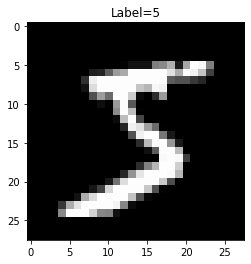

In [11]:
import matplotlib.pyplot as plt

i = 0
digit = train_set[i][0].reshape(28, 28)
label = train_set[i][1]
# digit = K[i].cpu().numpy().reshape(28, 28)
# label = np.argmax(V[i].cpu().numpy())
plt.title(f'Label={label}')
plt.imshow(digit, cmap='gray')
plt.show()

In [12]:
test_x, test_y = train_set[i]
test_x = prepare_device(test_x.reshape(-1, 28 * 28))
pred_y = model(test_x, K, V, beta)

In [13]:
pred_y

tensor([[-18006.6562, -19799.4844, -17350.2656, -17957.6719, -16595.9062,
         -15626.0156, -17232.7031, -19015.7344, -17262.0938, -17497.2188]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [14]:
Q = test_x @ model.WQ
Q = Q / torch.norm(Q, dim=1, keepdim=True)
K_ = K @ model.WK
K_ = K_ / torch.norm(K_, dim=1, keepdim=True)
V = V @ model.WV

Z = torch.softmax(beta * Q @ K_.T, dim=1) @ V
Z

tensor([[0.1021, 0.1123, 0.0984, 0.1018, 0.0941, 0.0886, 0.0977, 0.1078, 0.0979,
         0.0992]], device='cuda:0', grad_fn=<MmBackward0>)

In [15]:
V.shape

torch.Size([18000, 10])

In [16]:
K_.shape

torch.Size([18000, 32])

In [17]:
Q.shape

torch.Size([1, 32])

In [18]:
torch.max(model.WK.grad)

tensor(0., device='cuda:0')